In [1]:
!pip install matplotlib

  Using cached contourpy-1.2.1-cp312-cp312-macosx_11_0_arm64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 336.3 kB/s eta 0:00:00a 0:00:01
  Using cached kiwisolver-1.4.5-cp312-cp312-macosx_11_0_arm64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 336.7 kB/s eta 0:00:0000:0100:01
Using cached contourpy-1.2.1-cp312-cp312-macosx_11_0_arm64.whl (245 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 401.6 kB/s eta 0:00:0000:0100:01
Using cached kiwisolver-1.4.5-cp312-cp312-macosx_11_0_arm64.whl (64 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 307.8 kB/s eta 0:00:0000:0100:01
Using cached pyparsing-3.1.2-py3-none-any.whl (103 kB)


In [2]:
!pip install imblearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 189.4 kB/s eta 0:00:0000:0100:01


/Users/mohammadmahdi/Documents/test/nlp/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Main_Genre
Drama       610
Comedy      234
Action      109
Thriller     15
Romance       9
Name: count, dtype: int64


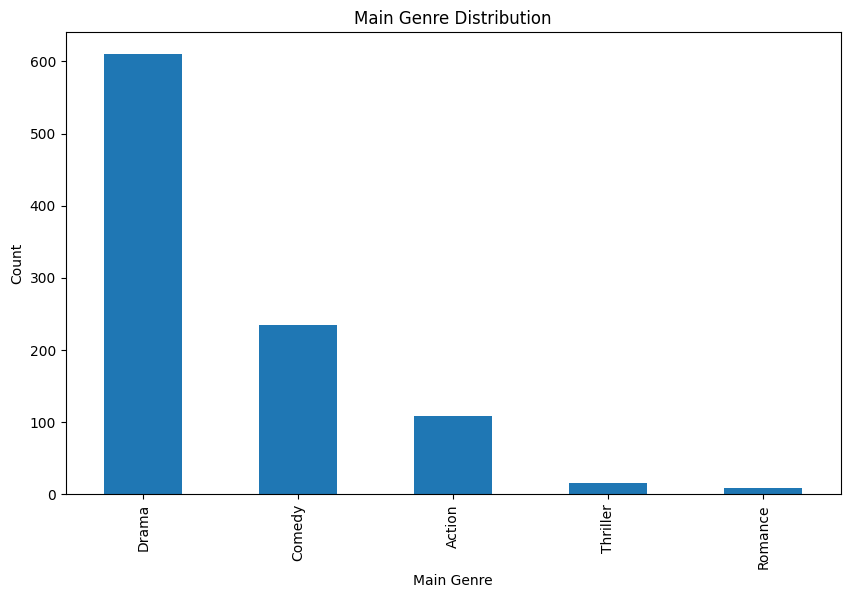

100%|██████████| 152/152 [41:17<00:00, 16.30s/it]


Epoch 1/10
Train loss: 1.2756921986215992
Validation loss: 1.1322383625166756
Validation accuracy: 0.6530612244897959


100%|██████████| 152/152 [39:38<00:00, 15.65s/it]


Epoch 2/10
Train loss: 1.013620063662529
Validation loss: 1.0792913266590662
Validation accuracy: 0.6428571428571429


100%|██████████| 152/152 [39:45<00:00, 15.70s/it]


Epoch 3/10
Train loss: 0.8333197455657156
Validation loss: 1.0969342248780387
Validation accuracy: 0.6122448979591837


100%|██████████| 152/152 [36:59<00:00, 14.60s/it]


Epoch 4/10
Train loss: 0.655855618417263
Validation loss: 1.0884121400969369
Validation accuracy: 0.5510204081632653


100%|██████████| 152/152 [29:34<00:00, 11.68s/it]


Epoch 5/10
Train loss: 0.4399954248709898
Validation loss: 1.1553443670272827
Validation accuracy: 0.5816326530612245


100%|██████████| 152/152 [29:09<00:00, 11.51s/it]


Epoch 6/10
Train loss: 0.18698855665953537
Validation loss: 1.2128189546721322
Validation accuracy: 0.5612244897959183


100%|██████████| 152/152 [29:16<00:00, 11.56s/it]


Epoch 7/10
Train loss: 0.13549286841512903
Validation loss: 1.2456623230661665
Validation accuracy: 0.5714285714285714


100%|██████████| 152/152 [29:15<00:00, 11.55s/it]


Epoch 8/10
Train loss: 0.09428678087792114
Validation loss: 1.282329065459115
Validation accuracy: 0.5816326530612245


100%|██████████| 152/152 [29:11<00:00, 11.52s/it]


Epoch 9/10
Train loss: 0.07823378012491096
Validation loss: 1.2937416093690055
Validation accuracy: 0.5612244897959183


100%|██████████| 152/152 [29:06<00:00, 11.49s/it]


Epoch 10/10
Train loss: 0.07273039854082622
Validation loss: 1.298807646547045
Validation accuracy: 0.5612244897959183
Test loss: 1.116172194480896
Test accuracy: 0.5612244897959183


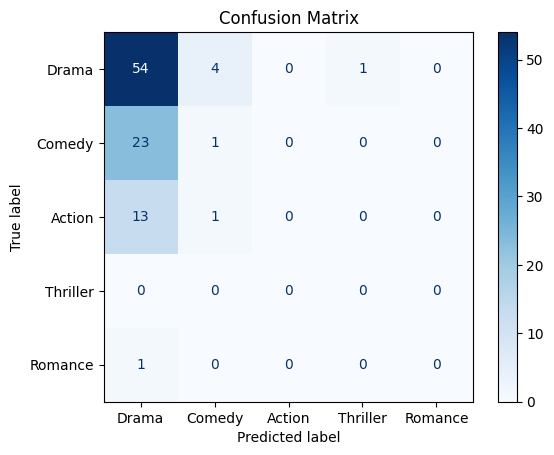

Predicted genre: Drama


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm import tqdm
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Custom BERT Model for Sequence Classification
class CustomBertForSequenceClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(CustomBertForSequenceClassification, self).__init__()
        self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        token_embeddings = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        logits = self.classifier(mean_embeddings)
        loss = None
        if labels is not None:
            loss = torch.nn.functional.cross_entropy(logits, labels)
        return loss, logits

# Load the dataset
file_path = 'dataset.csv'
df = pd.read_csv(file_path)

# Filter necessary columns
df = df[['Content_1', 'Genre']].dropna()

# Define a mapping of similar genres to main genres
genre_mapping = {
    'Drama': ['Drama', 'Biography', 'Documentary'],
    'Comedy': ['Comedy', 'Family', 'Animation'],
    'Action': ['Action', 'Adventure', 'Sci-Fi'],
    'Romance': ['Romance', 'Musical'],
    'Thriller': ['Thriller', 'Horror', 'Mystery']
}

# Function to map genres to main genres
def map_genre(genre):
    for main_genre, similar_genres in genre_mapping.items():
        if genre in similar_genres:
            return main_genre
    return None

# Apply the mapping
df['Main_Genre'] = df['Genre'].apply(map_genre)

# Drop rows with unmapped genres
df = df.dropna(subset=['Main_Genre'])

# Check the new distribution of main genres
main_genre_counts = df['Main_Genre'].value_counts()
print(main_genre_counts)

# Plot the distribution of main genres
plt.figure(figsize=(10, 6))
main_genre_counts.plot(kind='bar')
plt.title('Main Genre Distribution')
plt.xlabel('Main Genre')
plt.ylabel('Count')
plt.show()

# Convert labels to numerical format
label_to_id = {label: idx for idx, label in enumerate(df['Main_Genre'].unique())}
id_to_label = {idx: label for label, idx in label_to_id.items()}

df['Label'] = df['Main_Genre'].map(label_to_id)

# Split into features and labels
X = df['Content_1']
y = df['Label']

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Tokenize the summaries
tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased')

def tokenize_texts(texts):
    return tokenizer(texts.tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt')

X_train_encodings = tokenize_texts(X_train)
X_val_encodings = tokenize_texts(X_val)
X_test_encodings = tokenize_texts(X_test)

# Flatten the tokenized data for SMOTE
X_train_flat = X_train_encodings['input_ids'].view(len(X_train_encodings['input_ids']), -1).numpy()

# Apply SMOTE to balance the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train)

# Convert resampled data back to tensors
X_train_resampled = torch.tensor(X_train_resampled).view(-1, X_train_encodings['input_ids'].size(1))
y_train_resampled = torch.tensor(y_train_resampled.values)

# Convert y_train_resampled to Pandas Series to use value_counts
y_train_resampled_series = pd.Series(y_train_resampled.numpy())

# Calculate class weights
class_counts = y_train_resampled_series.value_counts()
class_weights = [1.0 / class_counts[label_to_id[label]] for label in df['Main_Genre'].unique()]
class_weights = torch.tensor(class_weights, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), dtype=torch.float32)

# Create Dataset class
class MovieDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Rebuild the encodings dictionary for the resampled data
train_encodings_resampled = {
    'input_ids': X_train_resampled,
    'attention_mask': torch.ones_like(X_train_resampled)  # Assuming all attention masks are 1
}

train_dataset = MovieDataset(train_encodings_resampled, y_train_resampled)
val_dataset = MovieDataset(X_val_encodings, torch.tensor(y_val.values))
test_dataset = MovieDataset(X_test_encodings, torch.tensor(y_test.values))

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Load the custom BERT model
model = CustomBertForSequenceClassification(num_labels=len(label_to_id))

# Ensure all layers are trainable
for param in model.parameters():
    param.requires_grad = True

# Set up optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Training function
def train(model, train_loader, optimizer, device):
    model.train()
    total_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
    return total_loss / len(train_loader)

# Evaluation function
def evaluate(model, val_loader, device):
    model.eval()
    total_loss = 0
    correct = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            loss, logits = model(input_ids, attention_mask=attention_mask, labels=labels)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            correct += (preds == labels).sum().item()
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return total_loss / len(val_loader), correct / len(val_loader.dataset), all_labels, all_preds

# Training loop with early stopping
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

num_epochs = 10
best_val_accuracy = 0
patience = 2
patience_counter = 0

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, device)
    val_loss, val_accuracy, val_labels, val_preds = evaluate(model, val_loader, device)
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train loss: {train_loss}")
    print(f"Validation loss: {val_loss}")
    print(f"Validation accuracy: {val_accuracy}")
    
    # Adjust the learning rate based on the validation loss
    scheduler.step(val_loss)
    
    # Save model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model.pt')
        patience_counter = 0
   

# Load the best model
model.load_state_dict(torch.load('best_model.pt'))

# Evaluation on Test Set
test_loss, test_accuracy, test_labels, test_preds = evaluate(model, test_loader, device)
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_accuracy}")

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[id_to_label[i] for i in range(len(label_to_id))])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Function for inference
def predict_genre(summary, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(summary, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        _, logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()
    return id_to_label[predicted_class]

# Example usage
summary = "سالار از طریق چوب بری قاچاق امرار معاش می کند. او یک بار هنگام قطع درخت، دستگیر، اره موتوری اش ضبط و روانه زندان می شود تا دوران محکومیت یک ساله اش را سپری کند. باجی همسر، جلال پسر، ماجان دختر - اعضای خانواده سالار - در غیاب او باید هزینه اره را به صاحب آن میرزا آقا بپردازند. ضمن اینکه ، قبل از واقعه اخیر قرار بوده تا ماجان با لطیف، سرباز اهری پاسگاه روستا ازدواج کند اما بعد از دستگیری سالار، چون باجی، لطیف را هنگام دستگیری شوهرش دیده است، پس در مورد ازدواج لطیف و ماجان تغییر عقیده می دهد. اما لطیف با پیگیری مستمر سعی می کند تا باجی را متقاعد به بی گناهی خود در دستگیری سالار و ازدواج خود با ماجان قانعش کند. جلال که رفتار نامناسب میرزا آقا را با مادرش به خاطر اره ضبط شده، می بیند، با او که رئیس قاچاقچیان چوب جنگل است توافق می کند تا درازای جبران خسارت وی، هر روزه برای فرج و عطا - قاچاقچیان چوب - اره را به میان جنگل ببرد. تحرکات پنهانی و غیبت های مستمر جلال، موجب حساسیت و نگرانی خانواده اش می شود. وقتی ماجان این نگرانی را با لطیف در میان می گذارد، او به تعقیب جلال در یک صبح زود می پردازد، اما لو میرود و توسط قاچاقچیان گرفتار و مورد ضرب و شتم قرار گرفته و جانش را ازدست میدهد. جلال، که در جریان این حادثه به بی گناهی لطیف و خیانت فرج آگاه شده می گریزد. فرج که دریافته او شاهد واقعه بوده، به تعقیبش می پردازد اما او را نمی یابد. باجی و ماجان که از ماوقع آگاه شده اند در جستجوری جلال برمی آیند و او را در درمانگاه روستا با چهره ای سخت پریشان و در هم می یابند، این زمانی است که سالار از زندان آزاد شده و به روستا بازگشته است. او به محض ورود به روستا سراغ لطیف را می گیرد."
predicted_genre = predict_genre(summary, model, tokenizer, device)
print(f"Predicted genre: {predicted_genre}")


In [4]:
pip install pandas numpy matplotlib scikit-learn transformers torch imbalanced-learn tqdm


Note: you may need to restart the kernel to use updated packages.


In [8]:
import torch
from transformers import BertTokenizer, BertModel

# Define the CustomBertForSequenceClassification class
class CustomBertForSequenceClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(CustomBertForSequenceClassification, self).__init__()
        self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        token_embeddings = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        logits = self.classifier(mean_embeddings)
        loss = None
        if labels is not None:
            loss = torch.nn.functional.cross_entropy(logits, labels)
        return loss, logits

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased')

# Define the label mappings
label_to_id = {
    'Drama': 0,
    'Comedy': 1,
    'Action': 2,
    'Romance': 3,
    'Thriller': 4
}
id_to_label = {v: k for k, v in label_to_id.items()}

# Initialize and load the model
model = CustomBertForSequenceClassification(num_labels=len(label_to_id))
model.load_state_dict(torch.load('best_model.pt'))
model.eval()


CustomBertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,),

In [9]:
# Function for inference
def predict_genre(summary, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(summary, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        _, logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()
    return id_to_label[predicted_class]

# Example usage
summary = "سالار از طریق چوب بری قاچاق امرار معاش می کند. او یک بار هنگام قطع درخت، دستگیر، اره موتوری اش ضبط و روانه زندان می شود تا دوران محکومیت یک ساله اش را سپری کند. باجی همسر، جلال پسر، ماجان دختر - اعضای خانواده سالار - در غیاب او باید هزینه اره را به صاحب آن میرزا آقا بپردازند. ضمن اینکه ، قبل از واقعه اخیر قرار بوده تا ماجان با لطیف، سرباز اهری پاسگاه روستا ازدواج کند اما بعد از دستگیری سالار، چون باجی، لطیف را هنگام دستگیری شوهرش دیده است، پس در مورد ازدواج لطیف و ماجان تغییر عقیده می دهد. اما لطیف با پیگیری مستمر سعی می کند تا باجی را متقاعد به بی گناهی خود در دستگیری سالار و ازدواج خود با ماجان قانعش کند. جلال که رفتار نامناسب میرزا آقا را با مادرش به خاطر اره ضبط شده، می بیند، با او که رئیس قاچاقچیان چوب جنگل است توافق می کند تا درازای جبران خسارت وی، هر روزه برای فرج و عطا - قاچاقچیان چوب - اره را به میان جنگل ببرد. تحرکات پنهانی و غیبت های مستمر جلال، موجب حساسیت و نگرانی خانواده اش می شود. وقتی ماجان این نگرانی را با لطیف در میان می گذارد، او به تعقیب جلال در یک صبح زود می پردازد، اما لو میرود و توسط قاچاقچیان گرفتار و مورد ضرب و شتم قرار گرفته و جانش را ازدست میدهد. جلال، که در جریان این حادثه به بی گناهی لطیف و خیانت فرج آگاه شده می گریزد. فرج که دریافته او شاهد واقعه بوده، به تعقیبش می پردازد اما او را نمی یابد. باجی و ماجان که از ماوقع آگاه شده اند در جستجوری جلال برمی آیند و او را در درمانگاه روستا با چهره ای سخت پریشان و در هم می یابند، این زمانی است که سالار از زندان آزاد شده و به روستا بازگشته است. او به محض ورود به روستا سراغ لطیف را می گیرد."
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
predicted_genre = predict_genre(summary, model, tokenizer, device)
print(f"Predicted genre: {predicted_genre}")


Predicted genre: Drama


In [12]:
import torch
from transformers import BertTokenizer, BertModel

# Define the CustomBertForSequenceClassification class
class CustomBertForSequenceClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(CustomBertForSequenceClassification, self).__init__()
        self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        token_embeddings = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        logits = self.classifier(mean_embeddings)
        loss = None
        if labels is not None:
            loss = torch.nn.functional.cross_entropy(logits, labels)
        return loss, logits

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased')

# Define the label mappings
label_to_id = {
    'Drama': 0,
    'Comedy': 1,
    'Action': 2,
    'Romance': 3,
    'Thriller': 4
}
id_to_label = {v: k for k, v in label_to_id.items()}

# Initialize and load the model
model = CustomBertForSequenceClassification(num_labels=len(label_to_id))
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Function for inference
def predict_genre(summary, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(summary, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        _, logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()
    return id_to_label[predicted_class]

# Function to evaluate multiple examples
def evaluate_examples(examples, model, tokenizer, device):
    correct_predictions = 0
    for summary, actual_genre in examples:
        predicted_genre = predict_genre(summary, model, tokenizer, device)
        is_correct = predicted_genre == actual_genre
        correct_predictions += is_correct
        print(f"Summary: {summary}")
        print(f"Actual Genre: {actual_genre}, Predicted Genre: {predicted_genre}, Correct: {is_correct}")
        print("------------------------------------------------------")
    accuracy = correct_predictions / len(examples)
    print(f"Accuracy: {accuracy * 100:.2f}%")

# Example summaries and their actual genres
examples = [
    ("یک دانشجوی فلسفه متوجه ازدواج پنهانی خواهرش با یک قمارباز می‌شود.", "Drama"),
    ("یک کارآگاه خصوصی یک پرونده گمشدگی پیچیده را حل می‌کند.", "Thriller"),
    ("یک تیم از دزدان حرفه‌ای تلاش می‌کنند یک بانک را سرقت کنند.", "Action"),
    ("یک زوج در یک شهر کوچک با مشکلات مالی دست و پنجه نرم می‌کنند.", "Drama"),
    ("یک دانشمند تلاش می‌کند درمانی برای یک بیماری مرگبار پیدا کند.", "Thriller"),
    ("یک مرد تنها در تلاش برای بقا در یک جهان پس از آخرالزمان است.", "Thriller"),
    ("یک دختر جوان به دنبال رویاهای خود به یک شهر بزرگ می‌رود.", "Romance"),
    ("یک گروه از دوستان به سفری ماجراجویانه می‌روند.", "Action"),
    ("یک زن کارآفرین با چالش‌های ایجاد یک شرکت نوپا مواجه می‌شود.", "Drama"),
    ("یک سرباز کهنه‌کار به خانه بازمی‌گردد و با گذشته‌اش مواجه می‌شود.", "Drama"),
    ("یک کودک با نیروهای فوق‌العاده تلاش می‌کند جهان را نجات دهد.", "Action"),
    ("یک جاسوس بین‌المللی تلاش می‌کند یک توطئه جهانی را کشف کند.", "Thriller"),
    ("یک خانواده در تلاش برای بقا در یک دنیای زامبی‌ها هستند.", "Thriller"),
    ("یک مامور مخفی تلاش می‌کند یک رئیس مافیا را دستگیر کند.", "Action"),
    ("یک هنرمند جوان تلاش می‌کند در دنیای هنر معروف شود.", "Drama"),
    ("یک زوج عاشق با چالش‌های خانوادگی مواجه می‌شوند.", "Romance"),
    ("یک گروه موسیقی جوان تلاش می‌کنند در صنعت موسیقی موفق شوند.", "Drama"),
    ("یک وکیل تلاش می‌کند یک پرونده جنایی بزرگ را حل کند.", "Thriller"),
    ("یک نویسنده معروف با بحران خلاقیت مواجه می‌شود.", "Drama"),
    ("یک پلیس تلاش می‌کند یک سری قتل‌های زنجیره‌ای را متوقف کند.", "Thriller")
]

# Evaluate the model on the examples
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
evaluate_examples(examples, model, tokenizer, device)


Summary: یک دانشجوی فلسفه متوجه ازدواج پنهانی خواهرش با یک قمارباز می‌شود.
Actual Genre: Drama, Predicted Genre: Drama, Correct: True
------------------------------------------------------
Summary: یک کارآگاه خصوصی یک پرونده گمشدگی پیچیده را حل می‌کند.
Actual Genre: Thriller, Predicted Genre: Drama, Correct: False
------------------------------------------------------
Summary: یک تیم از دزدان حرفه‌ای تلاش می‌کنند یک بانک را سرقت کنند.
Actual Genre: Action, Predicted Genre: Drama, Correct: False
------------------------------------------------------
Summary: یک زوج در یک شهر کوچک با مشکلات مالی دست و پنجه نرم می‌کنند.
Actual Genre: Drama, Predicted Genre: Drama, Correct: True
------------------------------------------------------
Summary: یک دانشمند تلاش می‌کند درمانی برای یک بیماری مرگبار پیدا کند.
Actual Genre: Thriller, Predicted Genre: Drama, Correct: False
------------------------------------------------------
Summary: یک مرد تنها در تلاش برای بقا در یک جهان پس از آخرالزمان است.
Ac

In [14]:
import torch
from transformers import BertTokenizer, BertModel

# Define the CustomBertForSequenceClassification class
class CustomBertForSequenceClassification(torch.nn.Module):
    def __init__(self, num_labels):
        super(CustomBertForSequenceClassification, self).__init__()
        self.bert = BertModel.from_pretrained('HooshvareLab/bert-fa-base-uncased')
        self.classifier = torch.nn.Linear(self.bert.config.hidden_size, num_labels)
    
    def forward(self, input_ids, attention_mask=None, token_type_ids=None, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        token_embeddings = outputs.last_hidden_state  # [batch_size, seq_len, hidden_size]
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
        sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
        mean_embeddings = sum_embeddings / sum_mask
        logits = self.classifier(mean_embeddings)
        loss = None
        if labels is not None:
            loss = torch.nn.functional.cross_entropy(logits, labels)
        return loss, logits

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained('HooshvareLab/bert-fa-base-uncased')

# Define the genre mappings
genre_mapping = {
    'Drama': ['Drama', 'Biography', 'Documentary'],
    'Comedy': ['Comedy', 'Family', 'Animation'],
    'Action': ['Action', 'Adventure', 'Sci-Fi'],
    'Romance': ['Romance', 'Musical'],
    'Thriller': ['Thriller', 'Horror', 'Mystery']
}

# Flatten the genre mapping to create label mappings
label_to_id = {}
for main_genre, sub_genres in genre_mapping.items():
    for genre in sub_genres:
        label_to_id[genre] = main_genre

# Map main genres to unique IDs
main_genres = list(genre_mapping.keys())
main_label_to_id = {main_genre: idx for idx, main_genre in enumerate(main_genres)}
main_id_to_label = {idx: main_genre for main_genre, idx in main_label_to_id.items()}

# Initialize and load the model
model = CustomBertForSequenceClassification(num_labels=len(main_label_to_id))
model.load_state_dict(torch.load('best_model.pt'))
model.eval()

# Function for inference
def predict_genre(summary, model, tokenizer, device):
    model.eval()
    inputs = tokenizer(summary, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        _, logits = model(inputs['input_ids'], attention_mask=inputs['attention_mask'])
    probs = torch.nn.functional.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs, dim=-1).item()
    return main_id_to_label[predicted_class]

# Function to evaluate multiple examples
def evaluate_examples(examples, model, tokenizer, device):
    correct_predictions = 0
    for summary, actual_genre in examples:
        predicted_genre = predict_genre(summary, model, tokenizer, device)
        main_actual_genre = label_to_id.get(actual_genre, actual_genre)
        is_correct = predicted_genre == main_actual_genre
        correct_predictions += is_correct
        print(f"Summary: {summary}")
        print(f"Actual Genre: {main_actual_genre}, Predicted Genre: {predicted_genre}, Correct: {is_correct}")
        print("------------------------------------------------------")
    accuracy = correct_predictions / len(examples)
    print(f"Accuracy: {accuracy * 100:.2f}%")

# Example summaries and their actual genres
examples = [
    ("یک دانشجوی فلسفه متوجه ازدواج پنهانی خواهرش با یک قمارباز می‌شود.", "Drama"),
    ("یک کارآگاه خصوصی یک پرونده گمشدگی پیچیده را حل می‌کند.", "Mystery"),
    ("یک تیم از دزدان حرفه‌ای تلاش می‌کنند یک بانک را سرقت کنند.", "Action"),
    ("یک زوج در یک شهر کوچک با مشکلات مالی دست و پنجه نرم می‌کنند.", "Drama"),
    ("یک دانشمند تلاش می‌کند درمانی برای یک بیماری مرگبار پیدا کند.", "Sci-Fi"),
    ("یک مرد تنها در تلاش برای بقا در یک جهان پس از آخرالزمان است.", "Adventure"),
    ("یک دختر جوان به دنبال رویاهای خود به یک شهر بزرگ می‌رود.", "Romance"),
    ("یک گروه از دوستان به سفری ماجراجویانه می‌روند.", "Adventure"),
    ("یک زن کارآفرین با چالش‌های ایجاد یک شرکت نوپا مواجه می‌شود.", "Drama"),
    ("یک سرباز کهنه‌کار به خانه بازمی‌گردد و با گذشته‌اش مواجه می‌شود.", "Drama"),
    ("یک کودک با نیروهای فوق‌العاده تلاش می‌کند جهان را نجات دهد.", "Fantasy"),
    ("یک جاسوس بین‌المللی تلاش می‌کند یک توطئه جهانی را کشف کند.", "Thriller"),
    ("یک خانواده در تلاش برای بقا در یک دنیای زامبی‌ها هستند.", "Horror"),
    ("یک مامور مخفی تلاش می‌کند یک رئیس مافیا را دستگیر کند.", "Action"),
    ("یک هنرمند جوان تلاش می‌کند در دنیای هنر معروف شود.", "Drama"),
    ("یک زوج عاشق با چالش‌های خانوادگی مواجه می‌شوند.", "Romance"),
    ("یک گروه موسیقی جوان تلاش می‌کنند در صنعت موسیقی موفق شوند.", "Drama"),
    ("یک وکیل تلاش می‌کند یک پرونده جنایی بزرگ را حل کند.", "Thriller"),
    ("یک نویسنده معروف با بحران خلاقیت مواجه می‌شود.", "Drama"),
    ("یک پلیس تلاش می‌کند یک سری قتل‌های زنجیره‌ای را متوقف کند.", "Thriller")
]

# Evaluate the model on the examples
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
evaluate_examples(examples, model, tokenizer, device)


Summary: یک دانشجوی فلسفه متوجه ازدواج پنهانی خواهرش با یک قمارباز می‌شود.
Actual Genre: Drama, Predicted Genre: Drama, Correct: True
------------------------------------------------------
Summary: یک کارآگاه خصوصی یک پرونده گمشدگی پیچیده را حل می‌کند.
Actual Genre: Thriller, Predicted Genre: Drama, Correct: False
------------------------------------------------------
Summary: یک تیم از دزدان حرفه‌ای تلاش می‌کنند یک بانک را سرقت کنند.
Actual Genre: Action, Predicted Genre: Drama, Correct: False
------------------------------------------------------
Summary: یک زوج در یک شهر کوچک با مشکلات مالی دست و پنجه نرم می‌کنند.
Actual Genre: Drama, Predicted Genre: Drama, Correct: True
------------------------------------------------------
Summary: یک دانشمند تلاش می‌کند درمانی برای یک بیماری مرگبار پیدا کند.
Actual Genre: Action, Predicted Genre: Drama, Correct: False
------------------------------------------------------
Summary: یک مرد تنها در تلاش برای بقا در یک جهان پس از آخرالزمان است.
Actu